In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from Model import Model
from PlaceInputs import PlaceInputs
from utils import *
import configs

# Initialize RNN

In [2]:
# Parameters
N_inp = 5000
N_bar = 5000
num_states = 100

In [3]:
place_inputs = PlaceInputs(N_inp, num_states).get_inputs()
model = Model(
    N_inp, N_bar, num_states,
    plasticity_bias = -0.45,
    narrow_search_factor=0.5, wide_search_factor=1.5,
    )

In [5]:
_, place_acts, _, _ = model.run_nonrecurrent(place_inputs)

# Add predictive skew to RNN weights

In [6]:
identity = np.eye(model.N_bar)
total_delta = np.zeros((model.N_bar, model.N_bar))
n_shifts = 500 
gamma = 0.99
for s in range(1, n_shifts):
    shifted = np.roll(identity, shift=-(s+50), axis=0)
    delta = (gamma**s)*0.04*shifted
    model.J_xx += delta
    total_delta += delta.copy()

In [7]:
_, cache_acts, _, _ = model.run_recurrent_r(place_inputs, 1.0)

# Get projections for each value of r

In [19]:
data = {
    'Projection': [],
    'r': [],
    'Mode': []
    }
for r in np.arange(0, 1.1, 0.1):
    _, acts, _, _ = model.run_recurrent_r(place_inputs, r)
    
    for row in range(acts.shape[0]):
        _act = acts[row].copy()
        _act = _act - _act.mean()
        _act = _act/np.linalg.norm(_act)
        
        _place = place_acts[row] / np.linalg.norm(place_acts[row])
        _cache = cache_acts[row]
        _bar = _cache - np.dot(_cache, _place) * _place
        _bar = _bar/np.linalg.norm(_bar)
        _pred = place_acts[(row+3)%num_states]
        _pred = _pred - np.dot(_pred, _place) * _place
        _pred = _pred/np.linalg.norm(_pred)
        _place_minus_pred = place_acts[row] - np.dot(place_acts[row], _pred) * _pred
        _place_minus_pred = _place_minus_pred/np.linalg.norm(_place_minus_pred)

        data['Projection'].append(np.dot(_act, _place_minus_pred))
        data['r'].append(r)
        data['Mode'].append('Place')
        
        data['Projection'].append(np.dot(_act, _pred))
        data['r'].append(r)
        data['Mode'].append('Pred')

        data['Projection'].append(np.dot(_act, _bar))
        data['r'].append(r)
        data['Mode'].append('Barcode')

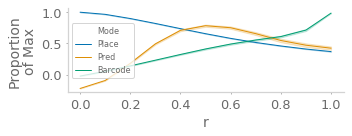

In [20]:
df = pd.DataFrame(data)
df.loc[df['Mode'] =='Pred', 'Projection'] /= np.max(df.loc[df['Mode'] =='Pred', 'Projection'])
df.loc[df['Mode'] =='Place', 'Projection'] /= np.max(df.loc[df['Mode'] =='Place', 'Projection'])
df.loc[df['Mode'] =='Barcode', 'Projection'] /= np.max(df.loc[df['Mode'] =='Barcode', 'Projection'])
plt.figure(figsize=(5,2))
sns.lineplot(
    x='r', y='Projection', hue='Mode',
    data=df, palette=['C0', 'C1', 'C2'],
    hue_order=['Place', 'Pred', 'Barcode'])
plt.ylabel('Proportion\nof Max')
plt.tight_layout()
plt.savefig('pred_rstrength.png', dpi=300)
plt.show()

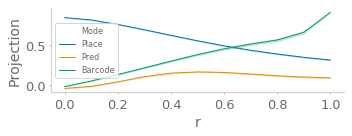

In [21]:
df = pd.DataFrame(data)
plt.figure(figsize=(5,2))
sns.lineplot(
    x='r', y='Projection', hue='Mode',
    data=df,
)
plt.ylabel('Projection')
plt.tight_layout()
plt.savefig('pred_rstrength.png', dpi=300)
plt.show()